In [1]:
import warnings
warnings.filterwarnings('ignore')
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from utils import scale_data, inverse_transform, lineplot, scatterplot

In [2]:
df = pd.read_excel('Data/all_data.xlsx')

In [3]:
df.tail()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063
365,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,65496611844,positif,92,61198.382813


# PREPROCESSING

In [4]:
df = df.drop(columns=['Date', 'Volume', 'Sentimen', 'Index', 'Adj_Close'])

In [5]:
X = df.drop('Close', axis=1)
y = df['Close']

In [6]:
X, y, scaler = scale_data(df)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# MODELING

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test):
    model = Sequential()    
    try:
        if n_lstm == 1:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        elif n_lstm == 2:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(units=neuron))
        else:
            print("Invalid LSTM configuration")

        model.add(Dense(25))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        history = model.fit(X_train, y_train, batch_size=32, epochs=epoch, validation_data=(X_test, y_test))

        return history 
    except Exception as e:
        print(f"Error during model training: {e}")
        return None 

def tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs):
    results = {} 

    for n_lstm in lstm_configs['n_lstm']:
        for neuron in lstm_configs['neurons']:
            for epoch in lstm_configs['epochs']:
                print(f'Running trial with n_lstm={n_lstm}, neuron={neuron}, epoch={epoch}')
                key = f'n_lstm={n_lstm}_neurons={neuron}_epochs={epoch}'
                history = declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test)
                
                if history is not None:
                    mse_train = history.history['loss'][-1] 
                    mse_test = history.history['val_loss'][-1]
                    results[key] = {'history': history.history, 'mse_train': mse_train, 'mse_test': mse_test}
                else:
                    print(f"Skipping combination n_lstm={n_lstm}, neuron={neuron}, epoch={epoch} due to error")

    return results

lstm_configs = {
    'n_lstm': [1, 2],  
    'neurons': [50, 100, 150, 200],  
    'epochs': [10, 20, 30] 
}

In [9]:
results = tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs)

Running trial with n_lstm=1, neuron=50, epoch=10
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0487 - val_loss: 0.0963
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - val_loss: 0.0390
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - val_loss: 0.0804
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124 - val_loss: 0.0968
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - val_loss: 0.0866
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0968
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_loss: 0.1095
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132 - val_loss: 0.1144
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - val_loss: 0.1208
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.1207
Running trial with n_lstm=1, neuron=50, epoch=20
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0

In [10]:
hasil = []

for key, value in results.items():
    mse_train = value['mse_train']
    mse_test = value['mse_test']
    hasil.append({
        'experiment': key,
        'mse_train': mse_train,
        'mse_test': mse_test
    })

hp_lstm = pd.DataFrame(hasil)

for result in hasil:
    print(f"Experiment: {result['experiment']}, MSE Train: {result['mse_train']}, MSE Test: {result['mse_test']}")

Experiment: n_lstm=1_neurons=50_epochs=10, MSE Train: 0.012479553930461407, MSE Test: 0.120659738779068
Experiment: n_lstm=1_neurons=50_epochs=20, MSE Train: 0.012323669157922268, MSE Test: 0.14214695990085602
Experiment: n_lstm=1_neurons=50_epochs=30, MSE Train: 0.0123893516138196, MSE Test: 0.13857240974903107
Experiment: n_lstm=1_neurons=100_epochs=10, MSE Train: 0.012676719576120377, MSE Test: 0.11515209823846817
Experiment: n_lstm=1_neurons=100_epochs=20, MSE Train: 0.012326953932642937, MSE Test: 0.1380896121263504
Experiment: n_lstm=1_neurons=100_epochs=30, MSE Train: 0.012416541576385498, MSE Test: 0.15254409611225128
Experiment: n_lstm=1_neurons=150_epochs=10, MSE Train: 0.012611162848770618, MSE Test: 0.11327949911355972
Experiment: n_lstm=1_neurons=150_epochs=20, MSE Train: 0.0123324329033494, MSE Test: 0.14100809395313263
Experiment: n_lstm=1_neurons=150_epochs=30, MSE Train: 0.012400002218782902, MSE Test: 0.13583411276340485
Experiment: n_lstm=1_neurons=200_epochs=10, MSE

In [11]:
hp_lstm

,experiment,mse_train,mse_test
0,n_lstm=1_neurons=50_epochs=10,0.012480,0.120660
1,n_lstm=1_neurons=50_epochs=20,0.012324,0.142147
2,n_lstm=1_neurons=50_epochs=30,0.012389,0.138572
3,n_lstm=1_neurons=100_epochs=10,0.012677,0.115152
4,n_lstm=1_neurons=100_epochs=20,0.012327,0.138090
5,n_lstm=1_neurons=100_epochs=30,0.012417,0.152544
6,n_lstm=1_neurons=150_epochs=10,0.012611,0.113279
7,n_lstm=1_neurons=150_epochs=20,0.012332,0.141008
8,n_lstm=1_neurons=150_epochs=30,0.012400,0.135834
9,n_lstm=1_neurons=200_epochs=10,0.012973,0.103721


In [12]:
hp_lstm.to_excel("kombinasi-parameter-2.xlsx")

In [13]:
max_mse_train_index = hp_lstm['mse_train'].idxmin()
max_mse_train_row = hp_lstm.loc[max_mse_train_index]
print(max_mse_train_row)

experiment    n_lstm=2_neurons=100_epochs=30
mse_train                           0.000332
mse_test                            0.001183
Name: 17, dtype: object


In [14]:
max_mse_test_index = hp_lstm['mse_test'].idxmin()
max_mse_test_row = hp_lstm.loc[max_mse_test_index]
print(max_mse_test_row)

experiment    n_lstm=2_neurons=200_epochs=30
mse_train                           0.000332
mse_test                            0.001096
Name: 23, dtype: object


In [15]:
exp = hp_lstm["experiment"]

n_lstm = exp.str.extract(r"n_lstm=(\d+)").astype(int)
neurons = exp.str.extract(r"neurons=(\d+)").astype(int)
epochs = exp.str.extract(r"epochs=(\d+)").astype(int)
mse_train = hp_lstm["mse_train"]
mse_test = hp_lstm["mse_test"]

hyperparam = pd.DataFrame({
    'n_lstm': n_lstm.squeeze(),
    'neurons': neurons.squeeze(),
    'epochs': epochs.squeeze(),
    'mse_train': mse_train,
    'mse_test': mse_test
})

In [16]:
hyperparam.head()

,n_lstm,neurons,epochs,mse_train,mse_test
0,1,50,10,0.012480,0.120660
1,1,50,20,0.012324,0.142147
2,1,50,30,0.012389,0.138572
3,1,100,10,0.012677,0.115152
4,1,100,20,0.012327,0.138090


In [17]:
best_config = hyperparam.loc[hyperparam["mse_test"].idxmin()]
best_config

n_lstm         2.000000
neurons      200.000000
epochs        30.000000
mse_train      0.000332
mse_test       0.001096
Name: 23, dtype: float64

In [18]:
n_lstm = int(best_config["n_lstm"])
neurons = int(best_config["neurons"])
epochs = int(best_config["epochs"])

model = Sequential()
for i in range(n_lstm):
    if i == 0:
        model.add(LSTM(neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif i < n_lstm - 1:
        model.add(LSTM(neurons, return_sequences=True))
    else:
        model.add(LSTM(neurons))

model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=2, validation_data=(X_test, y_test))

Epoch 1/30
10/10 - 2s - 154ms/step - loss: 0.0324 - val_loss: 0.0662
Epoch 2/30
10/10 - 0s - 5ms/step - loss: 0.0087 - val_loss: 0.0447
Epoch 3/30
10/10 - 0s - 5ms/step - loss: 0.0053 - val_loss: 0.0680
Epoch 4/30
10/10 - 0s - 5ms/step - loss: 0.0037 - val_loss: 0.0131
Epoch 5/30
10/10 - 0s - 5ms/step - loss: 0.0021 - val_loss: 0.0127
Epoch 6/30
10/10 - 0s - 5ms/step - loss: 8.1249e-04 - val_loss: 0.0012
Epoch 7/30
10/10 - 0s - 5ms/step - loss: 4.0042e-04 - val_loss: 0.0014
Epoch 8/30
10/10 - 0s - 5ms/step - loss: 3.9286e-04 - val_loss: 0.0013
Epoch 9/30
10/10 - 0s - 5ms/step - loss: 3.5886e-04 - val_loss: 0.0012
Epoch 10/30
10/10 - 0s - 5ms/step - loss: 3.4442e-04 - val_loss: 0.0012
Epoch 11/30
10/10 - 0s - 6ms/step - loss: 3.4000e-04 - val_loss: 0.0012
Epoch 12/30
10/10 - 0s - 6ms/step - loss: 3.4883e-04 - val_loss: 0.0013
Epoch 13/30
10/10 - 0s - 6ms/step - loss: 3.4926e-04 - val_loss: 0.0013
Epoch 14/30
10/10 - 0s - 6ms/step - loss: 3.7618e-04 - val_loss: 0.0011
Epoch 15/30
10/10 -

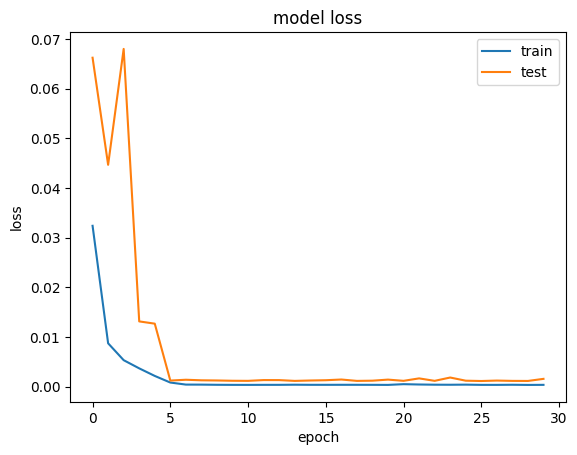

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [20]:
predictions_train = model.predict(X_train)

inverse_predictions_train = inverse_transform(scaler, predictions_train)
y_train_original = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]

compare_model_train = pd.DataFrame({'Predicted': inverse_predictions_train, 'Actual': y_train_original})
compare_model_train.head()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


,Predicted,Actual
0,23830.340079,23475.466797
1,23970.489131,22362.679688
2,23483.644366,22353.349609
3,22786.928204,22435.513672
4,22894.801620,22429.757813


In [21]:
predictions_test = model.predict(X_test)

inverse_predictions_test = inverse_transform(scaler, predictions_test)
y_test_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_test, 'Actual': y_test_original})
compare_model_test.head()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Predicted,Actual
0,42520.851240,42270.527344
1,43660.963590,43652.250000
2,44061.016508,43869.152344
3,44896.828337,43997.902344
4,45059.883858,43739.542969


# METRIKS EVALUASI

In [22]:
mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
rmse_model_train = np.sqrt(mse_model_train)
rmse_model_test = np.sqrt(mse_model_test)
print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
print("======================================================")

r2_xgb_train = r2_score(y_train, predictions_train)
r2_xgb_test = r2_score(y_test, predictions_test)
print("\nR-squared Train Set:", r2_xgb_train)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Train Set: 848.4266611757689
Root Mean Squared Error (RMSE) Test Set: 1667.876048352578

R-squared Train Set: 0.9673101490483293
R-squared Test Set: 0.8819173476471551


# VISUALISASI

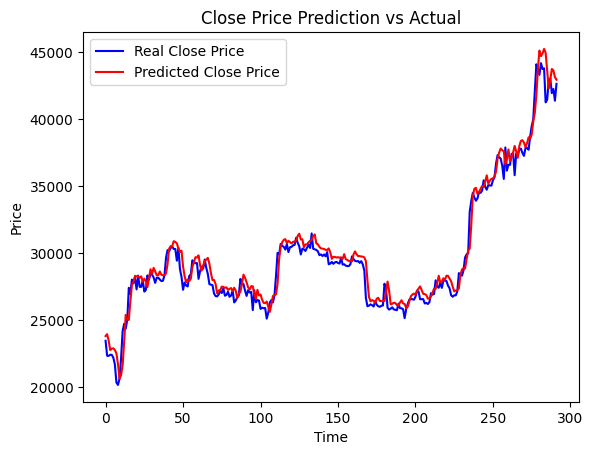

In [23]:
# lineplot train
lineplot(y_train_original, inverse_predictions_train)


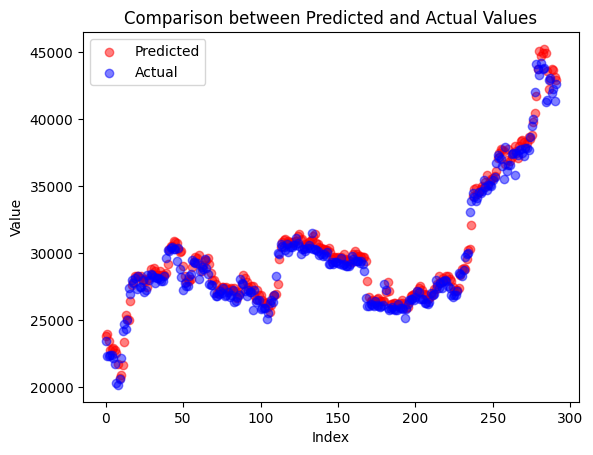

In [24]:
# scatterplot train
scatterplot(y_train_original, inverse_predictions_train)


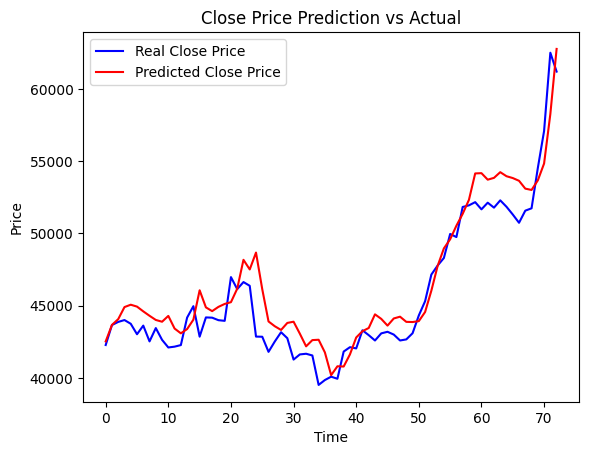

In [25]:
# lineplot test
lineplot(y_test_original, inverse_predictions_test)

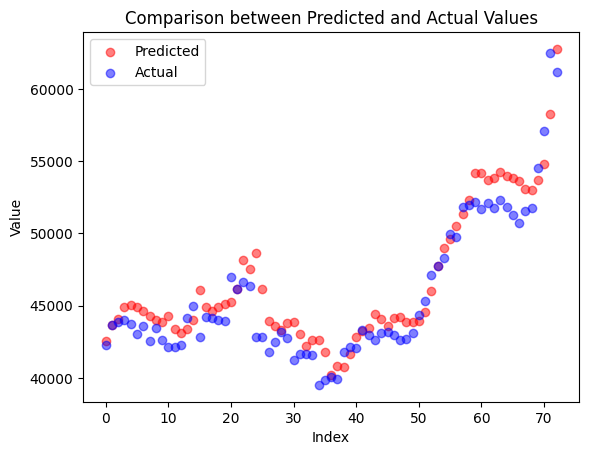

In [26]:
# scatterplot test
scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [27]:
X_train.shape

(292, 1, 3)

In [28]:
X_test.shape

(73, 1, 3)

In [ ]:
features = ["Open", "High", "Low"]

explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)